# CNN: Binary Classification

Sneakers:
1. Jordan 1 Retro High OG Chicago Lost and Found
2. adidas Yeezy Boost 350 V2 Black Red

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# useful PyTorch
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# google colab
from google.colab import drive

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Sneakers-Classifier-App/

/content/drive/MyDrive/Sneakers-Classifier-App


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

## Dataloading

In [6]:
# Resource: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class Sneakers(Dataset):
    # read the csv in __init__
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # __len__ so that len(dataset) returns the size of the dataset.
    def __len__(self):
        return len(self.labels)

    # __getitem__ to support the indexing such that dataset[i] can be used to get ith sample.
    def __getitem__(self, idx):

        # converts tensors to lists
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # create path of image by concatenating root dir and image name
        img_path = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = io.imread(img_path)
        # image = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

        # obtain label
        label = self.labels.iloc[idx, 1]

        # transform (if applicable)
        if self.transform:
            image = self.transform(image)

        return image, label

## Compute Image Statistics

In [7]:
train_df = pd.read_csv('train_dataset.csv')

In [8]:
len(train_df)

753

In [9]:
train_dataset = Sneakers(csv_file = "train_dataset.csv", root_dir = "clean/data/", transform=transforms.ToTensor())
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [10]:
# Resource: https://kozodoi.me/blog/20210308/compute-image-stats#:~:text=mean%3A%20simply%20divide%20the%20sum,%2F%20count%20%2D%20total_mean%20**%202)

# pixel sum and squared pixel sum
pixel_sum = torch.tensor([0.0, 0.0, 0.0]).to(device)
pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0]).to(device)

# loop through images
for inputs, _ in tqdm(train_loader):
    inputs = inputs.to(device)
    # 0 = batch, 2 = height, 3 = width
    pixel_sum += inputs.sum(axis = [0, 2, 3])
    pixel_sum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 12/12 [02:22<00:00, 11.87s/it]


In [11]:
# pixel count

# height = 100, width = 100
pixel_count = len(train_df) * 100 * 100

# mean and std
mean = pixel_sum / pixel_count
variance  = (pixel_sum_sq / pixel_count) - (mean ** 2)
std  = torch.sqrt(variance)

# output
print('mean: '  + str(mean))
print('std:  '  + str(std))

mean: tensor([0.5729, 0.5018, 0.4848], device='cuda:0')
std:  tensor([0.3116, 0.3283, 0.3247], device='cuda:0')


## Training CNN

In [12]:
# TODO

# if mean, std not calculated
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]

mean = [0.5729, 0.5018, 0.4848]
std = [0.3116, 0.3283, 0.3247]

# transformation pipeline
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(degrees=45),
                                transforms.Normalize(mean, std),
                                transforms.RandomPerspective(distortion_scale=0.3, p = 0.5)])

In [13]:
# load datasets
train_dataset = Sneakers(csv_file = "train_dataset.csv", root_dir = "clean/data/", transform=transform)
test_dataset = Sneakers(csv_file = "test_dataset.csv", root_dir = "clean/data/", transform=transform)

In [14]:
# dictionary to store label/shoes

d = {1: "AJ1", 0: "YZY"}

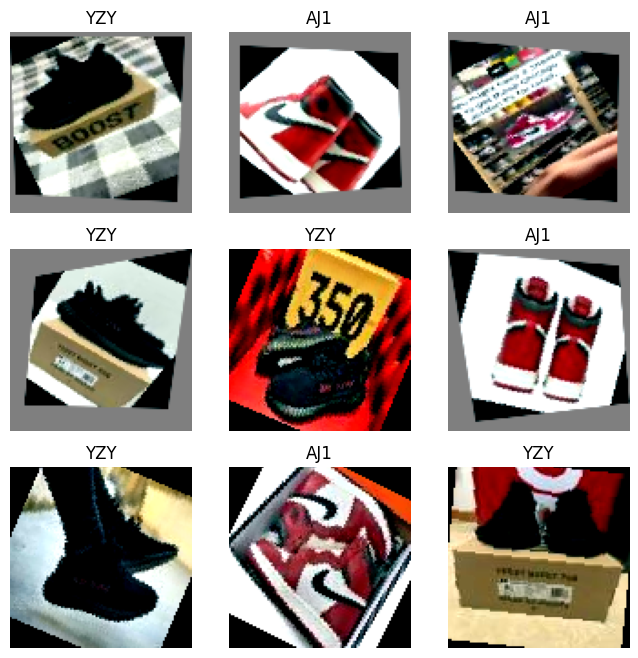

In [15]:
# plot images

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(0)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(d[label])
    plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)

In [16]:
# dataloader

train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 64, shuffle = True)

In [17]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # cnn layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(7744, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# move model to GPU
model = Net().to(device)

In [ ]:
# cross entropy loss
criterion = nn.CrossEntropyLoss()

# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loss = []
train_acc = []

num_epochs = 10
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        # store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device).long()

        # get the model predictions
        predictions = model(inputs)

        # zero the gradients out / reset the optimizer tensor
        # gradient every mini-batch
        optimizer.zero_grad()

        # compute loss
        loss = criterion(predictions, labels)
        print(loss)

        # calculate the gradients
        loss.backward()

        # update weights
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct/total)

    model.eval()
    running_loss = 0.
    correct, total = 0, 0


    print(f"Epoch {epoch+1}:")

    print(f"Training Loss:", round(train_loss[epoch], 3))

    print(f"Training Accuracy:", round(train_acc[epoch], 3))

    print("------------------------------")

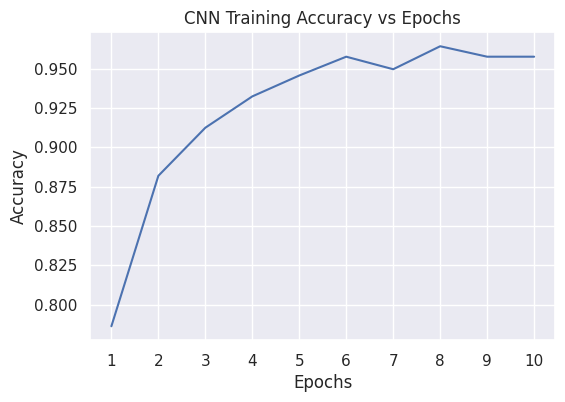

In [33]:
# plot training accuracy

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 11), np.array(train_acc))
plt.xticks(range(1, 11))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Training Accuracy vs Epochs")
plt.show()

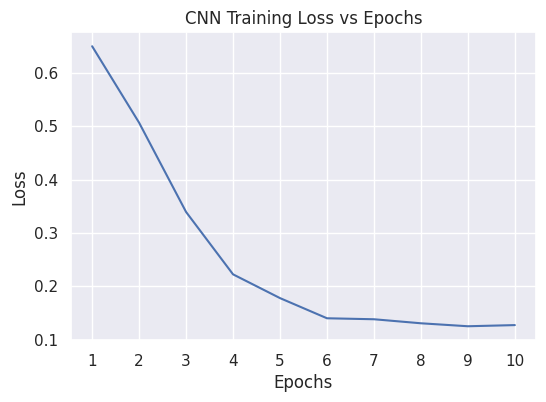

In [44]:
# plot training loss

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 11), np.array(train_loss))
plt.xticks(range(1, 11))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Training Loss vs Epochs")
plt.show()

In [35]:
test_acc = []

model.eval()
total = 0
correct = 0
test_predictions = np.array([])


for i, data in enumerate(test_loader, 0):

    inputs, labels = data

    # store in GPU
    inputs = inputs.to(device)

    # model prediction
    predictions = model(inputs)

    # get predicted value
    _, predicted = torch.max(predictions, 1)

    correct += (predicted.detach().cpu() == labels).float().sum()
    total += len(labels)

test_acc_CNN = 100 * correct / total

In [36]:
test_acc_CNN

tensor(96.8254)

## Confusion Matrix

In [41]:
def cm_generator(test_loader):
  preds = []
  actual = []
  with torch.no_grad():
    for images, labels in test_loader:
      labels = labels.type(torch.LongTensor)
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      predictions = outputs.argmax(dim=1)

      preds.extend(predictions.detach().cpu().numpy())
      actual.extend(labels.detach().cpu().numpy())

  return preds, actual

In [42]:
preds, actual = cm_generator(test_loader)
confusion_matrix_df = pd.DataFrame(confusion_matrix(preds, actual))

In [43]:
confusion_matrix_df

,0,1
0,112,8
1,3,129


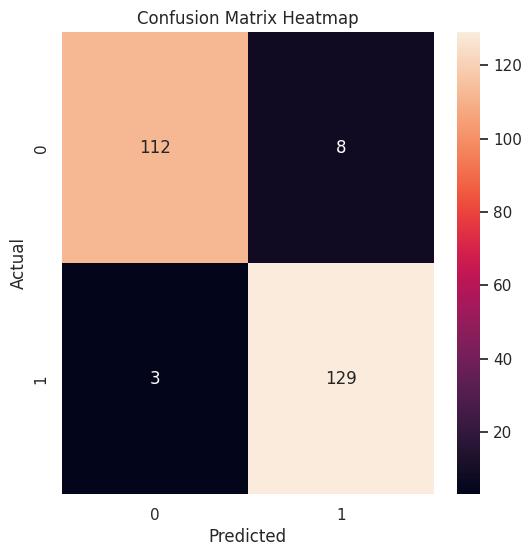

In [47]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_df, annot = True, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()